# Human Activity Recognition with samrtphone

This notebook explores various machine learning techniques for classification tasks. We begin by applying random forest to filter the dataset, aiming to improve model performance and reduce overfitting. Subsequently, we employ logistic regression, multilayer perceptron (MLP), and one-dimensional convolutional neural networks (Conv1D) to build and evaluate classification models. The goal is to compare the effectiveness of these approaches and identify the most suitable method for our given problem.

## Downloading and Imports

In [ ]:
!pip install -Uqq fastai

In [ ]:
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from fastai.vision.all import *

In [ ]:
creds = ''

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    print("writing cred to a file in {}".format(cred_path))
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

writing cred to a file in /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d uciml/human-activity-recognition-with-smartphones

Dataset URL: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones
License(s): CC0-1.0
 53% 13.0M/24.5M [00:00<00:00, 60.5MB/s]
100% 24.5M/24.5M [00:00<00:00, 77.3MB/s]


In [ ]:
path = Path("/content/data")
if not path.exists():
  path.parent.mkdir(exist_ok=True)
  path.mkdir(exist_ok=True)

shutil.unpack_archive('/content/human-activity-recognition-with-smartphones.zip', str(path))

path.ls()

(#2) [Path('/content/data/train.csv'),Path('/content/data/test.csv')]

## Looking at the Data

In [ ]:
df = pd.read_csv(path/"train.csv", low_memory=False)
df_test = pd.read_csv(path/"test.csv", low_memory=False)

In [ ]:
df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


In [ ]:
df["Activity"].dtype

dtype('O')

In [ ]:
df["Activity"].head()

,Activity
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [ ]:
df["Activity"].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [ ]:
df["Activity"].value_counts()

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [ ]:
dep_variable = "Activity"
X_train = df.drop(dep_variable, axis=1)
X_test = df_test.drop(dep_variable, axis=1)
y_train = df[dep_variable]
y_test = df_test[dep_variable]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Feature Selection

With high dimensional data feature selection is important to reduce overfitting, lowering training time, and improve inference perfermance.

In this section we will try some techniques to filter out unnessecary or low importance data

### Removing duplicate Columns

In [ ]:
def get_duplicate_columns(df):

    duplicate_columns = {}
    seen_columns = {}

    for column in df.columns:
        current_column = df[column]

        # Convert column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()
        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [ ]:
duplicate_columns = get_duplicate_columns(X_train)
duplicate_columns

{'tBodyAccMag-mean()': ['tBodyAccMag-sma()',
  'tGravityAccMag-mean()',
  'tGravityAccMag-sma()'],
 'tBodyAccMag-std()': ['tGravityAccMag-std()'],
 'tBodyAccMag-mad()': ['tGravityAccMag-mad()'],
 'tBodyAccMag-max()': ['tGravityAccMag-max()'],
 'tBodyAccMag-min()': ['tGravityAccMag-min()'],
 'tBodyAccMag-energy()': ['tGravityAccMag-energy()'],
 'tBodyAccMag-iqr()': ['tGravityAccMag-iqr()'],
 'tBodyAccMag-entropy()': ['tGravityAccMag-entropy()'],
 'tBodyAccMag-arCoeff()1': ['tGravityAccMag-arCoeff()1'],
 'tBodyAccMag-arCoeff()2': ['tGravityAccMag-arCoeff()2'],
 'tBodyAccMag-arCoeff()3': ['tGravityAccMag-arCoeff()3'],
 'tBodyAccMag-arCoeff()4': ['tGravityAccMag-arCoeff()4'],
 'tBodyAccJerkMag-mean()': ['tBodyAccJerkMag-sma()'],
 'tBodyGyroMag-mean()': ['tBodyGyroMag-sma()'],
 'tBodyGyroJerkMag-mean()': ['tBodyGyroJerkMag-sma()'],
 'fBodyAccMag-mean()': ['fBodyAccMag-sma()'],
 'fBodyBodyAccJerkMag-mean()': ['fBodyBodyAccJerkMag-sma()'],
 'fBodyBodyGyroMag-mean()': ['fBodyBodyGyroMag-sma()'

In [ ]:
X_train[['tBodyAccMag-mean()','tBodyAccMag-sma()','tGravityAccMag-mean()','tGravityAccMag-sma()']]

,tBodyAccMag-mean(),tBodyAccMag-sma(),tGravityAccMag-mean(),tGravityAccMag-sma()
0,-0.959434,-0.959434,-0.959434,-0.959434
1,-0.979289,-0.979289,-0.979289,-0.979289
2,-0.983703,-0.983703,-0.983703,-0.983703
3,-0.986542,-0.986542,-0.986542,-0.986542
4,-0.992827,-0.992827,-0.992827,-0.992827
...,...,...,...,...
7347,-0.031719,-0.031719,-0.031719,-0.031719
7348,-0.065256,-0.065256,-0.065256,-0.065256
7349,-0.003936,-0.003936,-0.003936,-0.003936
7350,-0.002445,-0.002445,-0.002445,-0.002445


In [ ]:
for one_list in duplicate_columns.values():
    X_train.drop(columns=one_list,inplace=True)
    X_test.drop(columns=one_list,inplace=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7352, 541)
(2947, 541)


### Creating a Random Forest

We will use random forest model to determine which feature is the least importance to our final prediction.

In [ ]:
def rf(xs, y, n_estimators=50, max_samples=3000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
# getting a base model / score
m = rf(X_train, y_train);
pred_y = m.predict(X_test)

macro_f1 = f1_score(y_test, pred_y, average='macro')

print(f"Macro f1 score of random forest: {macro_f1}")

Macro f1 score of random forest: 0.8997287047554142


### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, X_train)
fi[10:20]

,cols,imp
74,"tGravityAcc-arCoeff()-Z,2",0.021904
487,fBodyAccMag-mad(),0.021339
69,"tGravityAcc-arCoeff()-Y,1",0.017990
102,tBodyAccJerk-entropy()-X,0.017723
364,"fBodyAccJerk-bandsEnergy()-1,8",0.017109
297,"fBodyAcc-bandsEnergy()-1,24",0.016866
86,tBodyAccJerk-mad()-X,0.016794
75,"tGravityAcc-arCoeff()-Z,3",0.016235
254,fBodyAcc-mad()-X,0.015303
73,"tGravityAcc-arCoeff()-Z,1",0.015185


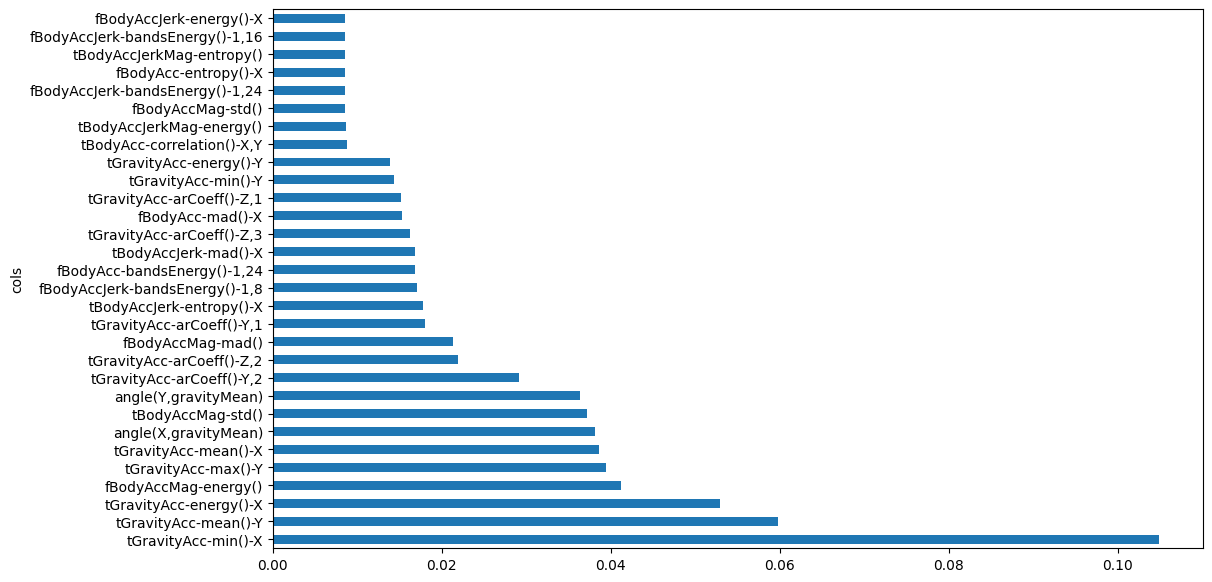

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>=0.002].cols
len(to_keep)

62

In [ ]:
X_train_imp = X_train[to_keep]
X_test_imp = X_test[to_keep]

In [ ]:
m = rf(X_train_imp, y_train)

pred_y = m.predict(X_test_imp)

macro_f1 = f1_score(y_test, pred_y, average='macro')

print(f"Macro f1 score of random forest using most important features: {macro_f1}")

Macro f1 score of random forest using most important features: 0.8972842084024105


### Removing Redundant Features

In [ ]:
from scipy.cluster import hierarchy as hc

In [ ]:
def cluster_columns(df, figsize=(10, 12), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

In [ ]:
def cluster_columns_lowest(df, correlation_level):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    correlated_pairs = []
    for i in range(len(z)):
      if z[i, 2] <= correlation_level:
        left, right = z[i, 0:2]
        if left < len(df.columns) and right < len(df.columns):
          correlated_pairs.append((df.columns[int(left)], df.columns[int(right)]))

    return correlated_pairs

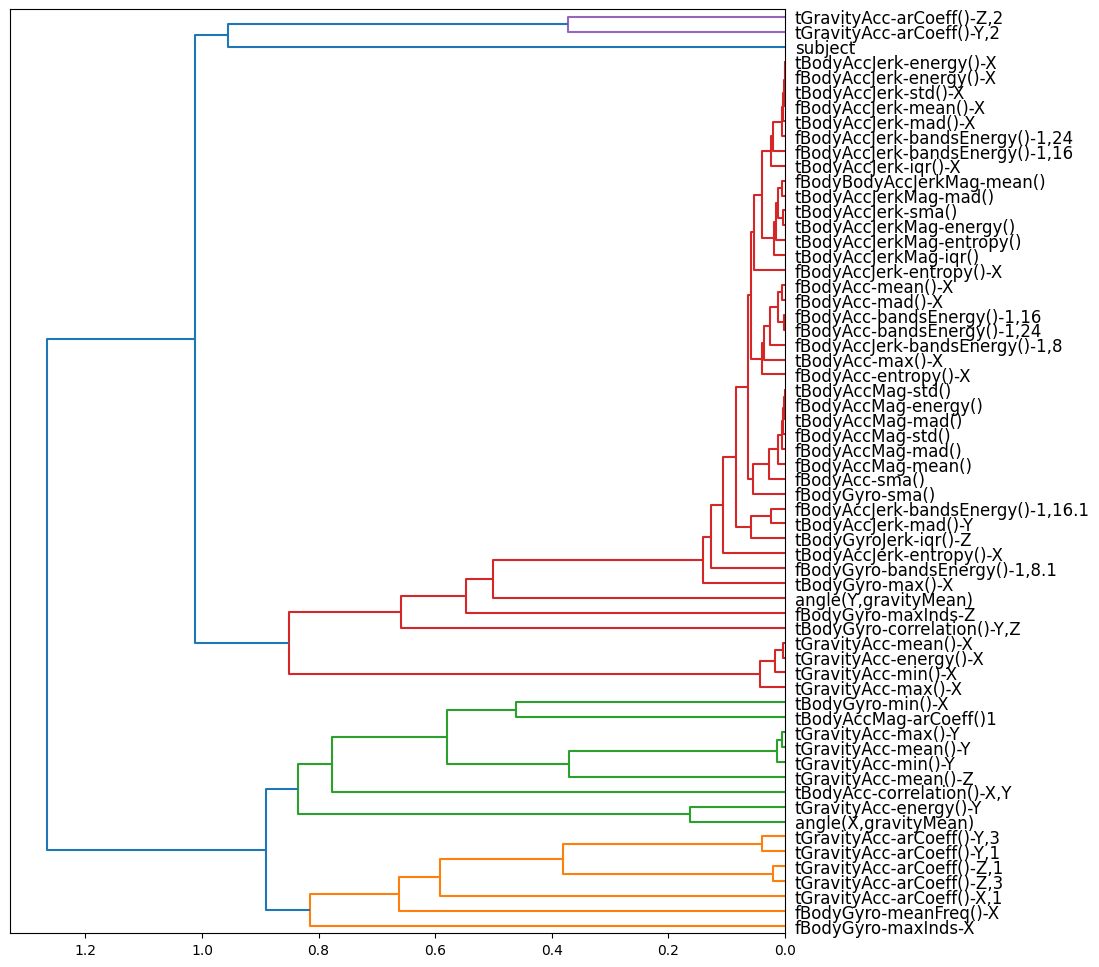

In [ ]:
cluster_columns(X_train_imp)

In [ ]:
cluster = cluster_columns_lowest(X_train_imp, 0.1)

In [ ]:
def get_oob(df, y):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=550, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(X_train_imp, y_train)

0.9182535364526659

In [ ]:
columns = []
for c in cluster:
  columns.extend(list(c))
oob_col_scores = {c:get_oob(X_train_imp.drop(c, axis=1), y_train) for c in columns}

In [ ]:
to_drop = [e1 if oob_col_scores[e1] >= oob_col_scores[e2] else e2
           for e1, e2 in cluster]
get_oob(X_train_imp.drop(to_drop, axis=1), y_train)

0.920429815016322

In [ ]:
X_train_final = X_train_imp.drop(to_drop, axis=1)
X_test_final = X_test_imp.drop(to_drop, axis=1)

In [ ]:
m = rf(X_train_final, y_train, n_estimators=40, min_samples_leaf=15, max_features=550)

pred_y = m.predict(X_test_final)

macro_f1 = f1_score(y_test, pred_y, average='macro')

print(f"Macro f1 score of random forest using most important features: {macro_f1}")

Macro f1 score of random forest using most important features: 0.8885564800843664


## visualizing using PCA

visualizing the selected feature using principil component analysis

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_train_final)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  7352 non-null   float64
 1   principal component 2  7352 non-null   float64
dtypes: float64(2)
memory usage: 115.0 KB


In [ ]:
finalDf = pd.concat([principalDf, df[dep_variable]], axis = 1, ignore_index=False)

In [ ]:
finalDf["Activity"].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [ ]:
finalDf[dep_variable].value_counts(dropna=False)

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [ ]:
finalDf.head()

,principal component 1,principal component 2,Activity
0,-16.354411,-2.199106,STANDING
1,-16.356838,-2.236781,STANDING
2,-16.357032,-2.224936,STANDING
3,-16.358037,-2.254990,STANDING
4,-16.356622,-2.308765,STANDING


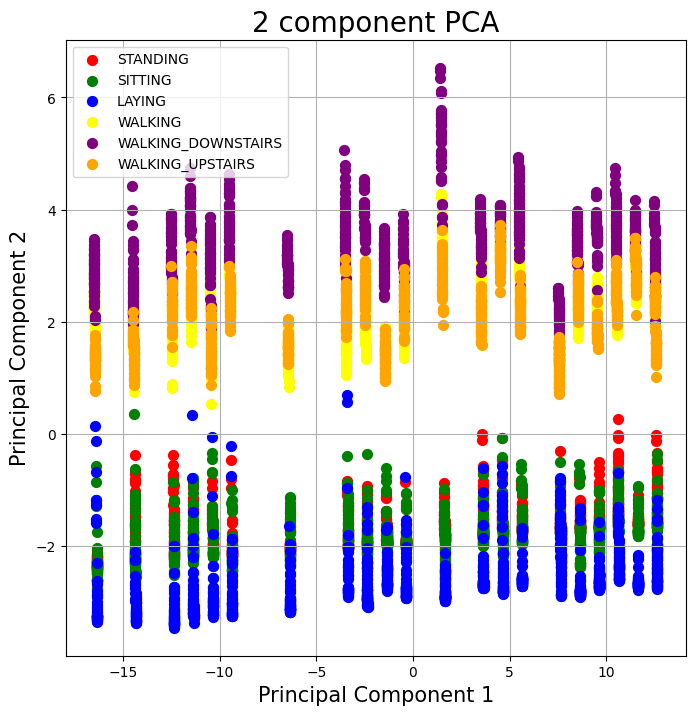

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[dep_variable] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend([t for t in targets])
ax.grid()

## Using TabularPandas

Using TabularPandas gives us some handy features that makes training a neural net easier without adding any additional hassle when using it with outher models.

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(X_train_final.index, test_size=0.2, random_state=42)

splits = (list(train), list(valid))

In [ ]:
type(splits), len(splits[0]), len(splits[1])

(tuple, 5881, 1471)

In [ ]:
cont,cat = cont_cat_split(X_train_final, 1, dep_var=None)

In [ ]:
df = pd.concat([X_train_final, df[dep_variable]], axis=1)
df_test = pd.concat([X_test_final, df_test[dep_variable]], axis=1)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_variable, splits=splits)
to_test = TabularPandas(df_test, procs, cat, cont, y_names=dep_variable, splits=None)

In [ ]:
len(to.train),len(to.valid)

(5881, 1471)

In [ ]:
to.show(3)

,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-X,"angle(X,gravityMean)",tBodyAccMag-std(),"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Z,2",fBodyAccMag-mad(),tBodyAccJerk-entropy()-X,"fBodyAccJerk-bandsEnergy()-1,8",tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Z,3",tGravityAcc-min()-Y,tGravityAcc-energy()-Y,"tBodyAcc-correlation()-X,Y",fBodyAccMag-std(),"fBodyAccJerk-bandsEnergy()-1,24",fBodyAcc-entropy()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",fBodyAccJerk-energy()-X,fBodyAccJerk-mean()-X,fBodyGyro-maxInds-X,tBodyAccJerk-iqr()-X,"tBodyGyro-correlation()-Y,Z",tBodyAccMag-arCoeff()1,"tGravityAcc-arCoeff()-X,1",tGravityAcc-max()-X,fBodyAccMag-mean(),"fBodyAcc-bandsEnergy()-1,16",tBodyAccJerkMag-mad(),tBodyAccMag-mad(),"tGravityAcc-arCoeff()-Y,3",tBodyAccJerk-mad()-Y,tBodyGyroJerk-iqr()-Z,fBodyGyro-sma(),tBodyAccJerk-sma(),tBodyAccJerkMag-iqr(),fBodyAcc-mean()-X,fBodyAccJerk-entropy()-X,tBodyAccJerk-std()-X,fBodyAcc-sma(),tBodyGyro-max()-X,fBodyGyro-maxInds-Z,tBodyAcc-max()-X,tGravityAcc-mean()-Z,tBodyGyro-min()-X,fBodyGyro-meanFreq()-X,subject,"fBodyGyro-bandsEnergy()-1,8.1",Activity
57,-0.163251,0.771351,-0.934984,0.398881,-0.996333,-0.546717,-0.261909,0.163357,-0.995165,-0.769828,-0.999991,-0.992652,-0.187326,0.786554,0.202228,-0.033535,-0.996299,-0.999933,-0.946357,-0.815909,-0.999945,-0.999913,-0.992500,-0.4,-0.994739,0.573381,0.476707,-0.380755,-0.277682,-0.996037,-0.999964,-0.994087,-0.996446,0.266810,-0.989069,-0.996372,-0.996283,-0.993341,-0.993503,-0.994037,-1.000000,-0.991940,-0.995532,-0.886909,-1.000000,-0.938974,0.589635,0.845001,0.327644,1.0,-0.999962,LAYING
4154,0.793836,-0.426314,0.451282,-0.474013,-0.398585,0.383162,0.582097,0.551496,-0.331245,0.524181,-0.825206,-0.479702,-0.592987,-0.406240,-0.678314,-0.170299,-0.498946,-0.887685,0.316600,0.567493,-0.886711,-0.887736,-0.561118,-1.0,-0.358028,0.386081,-0.352672,-0.731530,0.717677,-0.385808,-0.756416,-0.570175,-0.471632,-0.607285,-0.261402,-0.502770,-0.367357,-0.411062,-0.603236,-0.462260,0.277542,-0.531375,-0.242063,-0.339631,-0.931035,-0.310961,-0.305974,0.678702,-0.133927,21.0,-0.898022,WALKING_UPSTAIRS
6945,0.938414,-0.200880,0.875585,-0.819001,0.086967,0.221549,0.572579,0.895134,0.214872,0.534448,-0.680180,-0.138687,-0.911576,-0.208714,-0.934913,-0.420902,-0.068880,-0.524136,0.668606,0.747878,-0.640941,-0.588443,-0.178260,-1.0,-0.225193,0.237400,-0.463560,-0.615555,0.895073,0.062909,-0.521349,-0.208280,-0.051454,-0.603507,-0.259662,-0.517197,-0.315806,-0.311047,-0.338012,-0.056719,0.662595,-0.096481,-0.007059,-0.179053,-0.586207,0.370607,0.036311,0.684212,-0.387886,29.0,0.192158,WALKING_UPSTAIRS


## Logistic Regression

Starting with our simpliest model and probably the best in this senario Logistic Regression.

We will try using training the model with and without PCA and record the difference.

In [ ]:
len(to.train.xs.columns)

51

In [ ]:
import random

def generate_tuple(c_values, solvers, l1_ratio):
  """
  Generates a random tuple containing values from the given lists.

  Args:
    c_values: A list of possible values for the first element of the tuple.
    solvers: A list of possible values for the second element of the tuple.
    l1_ratio: A list of possible values for the third element of the tuple.

  Returns:
    A tuple containing a randomly chosen value from each list.
  """

  # Generate random values within the specified ranges (inclusive)
  c_value = random.uniform(c_values[0], c_values[1])
  l1_ratio = random.uniform(l1_ratio[0], l1_ratio[1])

  return (
    c_value,
    random.choice(solvers),
    l1_ratio
  )

In [ ]:
c_values = [0.1, 2.0]
solvers = ["lbfgs", "saga", "sag"]
l1_ratio = [0.1, 0.9]

tried_values = [[], [], [], []]
for i in range(15):
  c, s, r = generate_tuple(c_values, solvers, l1_ratio)
  print(f"iteration: {i}")

  # apply transformation
  xs = to.train.xs
  valid_xs = to.valid.xs

  # fitting logistic regression
  if s == "saga":
    logisticRegr = LogisticRegression(C=c, solver=s, penalty="elasticnet", l1_ratio=r, max_iter=1300)
  else:
    logisticRegr = LogisticRegression(C=c, solver=s, penalty="l2", max_iter=1300)
    r = None
  estimator = logisticRegr.fit(xs, to.train.y)

  # predicting and calculating score
  pred_y = estimator.predict(valid_xs)
  macro_f1 = f1_score(to.valid.y, pred_y, average='macro')

  # logging
  tried_values[0].append(macro_f1)
  tried_values[1].append(c)
  tried_values[2].append(s)
  tried_values[3].append(r)

iteration: 0
iteration: 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


iteration: 2
iteration: 3
iteration: 4
iteration: 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


iteration: 12
iteration: 13
iteration: 14


In [ ]:
data = {key: v for key, v in zip(["macro_f1", "c", "solver", "l1_ratio"], tried_values)}
log_df = pd.DataFrame(data=data)
log_df

,macro_f1,c,solver,l1_ratio
0,0.955754,0.105282,sag,NaN
1,0.959471,1.921598,saga,0.704149
2,0.956663,1.242872,sag,NaN
3,0.957794,0.839340,saga,0.436940
4,0.958520,1.525296,lbfgs,NaN
5,0.958855,1.362357,saga,0.699767
6,0.957289,0.767833,lbfgs,NaN
7,0.957289,0.797887,sag,NaN
8,0.955728,0.723837,lbfgs,NaN
9,0.958657,0.261694,saga,0.685075


In [ ]:
log_df.macro_f1.max()

0.959470704572806

In [ ]:
model_metrics = {
    "macro_f1": [],
    "number_of_components": []
}

c_values = [0.05, 0.1, 0.25, 0.5, 1.5]
variance_retained = [0.99, 0.95, 0.95, 0.9, 0.9]

In [ ]:
n = 0
for c, v in zip(c_values, variance_retained):
  print(f"number: {n}")
  n += 1
  # fitting PCA to a variance
  pca = PCA(n_components=v)
  pca.fit(to.train.xs)

  # apply transformation
  xs = pca.transform(to.train.xs)
  valid_xs = pca.transform(to.valid.xs)

  # fitting logistic regression
  logisticRegr = LogisticRegression(C=c, solver='saga', penalty="elasticnet", l1_ratio=0.4, max_iter=1300)
  estimator = logisticRegr.fit(xs, to.train.y)

  # predicting and calculating score
  pred_y = estimator.predict(valid_xs)
  macro_f1 = f1_score(to.valid.y, pred_y, average='macro')

  # logging
  model_metrics["macro_f1"].append(macro_f1)
  model_metrics["number_of_components"].append(pca.n_components_)

number: 0
number: 1
number: 2
number: 3
number: 4


In [ ]:
model_metrics["c_value"] = c_values
model_metrics["variance_retained"] = variance_retained

metric_df = pd.DataFrame(model_metrics)
metric_df

,macro_f1,number_of_components,c_value,variance_retained
0,0.942168,21,0.05,0.99
1,0.937110,14,0.10,0.95
2,0.940921,14,0.25,0.95
3,0.914592,9,0.50,0.90
4,0.917742,9,1.50,0.90


In [ ]:
logisticRegr = LogisticRegression(C=1.0, solver="saga", penalty="elasticnet", l1_ratio=0.7, max_iter=1400)
estimator = logisticRegr.fit(to.train.xs, to.train.y)

# predicting and calculating score
pred_y = estimator.predict(to_test.train.xs)
macro_f1 = f1_score(to_test.train.y, pred_y, average='macro')
acc_score = accuracy_score(to_test.train.y, pred_y)

print(f"Macro f1 score of ligistic Regression on the test set: {macro_f1}")
print(f"accuarcy score of ligistic Regression on the test set: {acc_score}")

Macro f1 score of ligistic Regression on the test set: 0.9262285740119363
accuarcy score of ligistic Regression on the test set: 0.9256871394638616


In [ ]:
# fitting PCA to a variance
pca = PCA(n_components=0.99)
pca.fit(to.train.xs)

# apply transformation
xs = pca.transform(to.train.xs)
test_xs = pca.transform(to_test.train.xs)

# fitting logistic regression
logisticRegr = LogisticRegression(C=0.05, solver='saga', penalty="elasticnet", l1_ratio=0.5, max_iter=1300)
estimator = logisticRegr.fit(xs, to.train.y)

# predicting and calculating score
pred_y = estimator.predict(test_xs)
macro_f1 = f1_score(to_test.train.y, pred_y, average='macro')
acc_score = accuracy_score(to_test.train.y, pred_y)

print(f"Macro f1 score of ligistic Regression on the test set: {macro_f1}")
print(f"accuarcy score of ligistic Regression on the test set: {acc_score}")

Macro f1 score of ligistic Regression on the test set: 0.9117655676736617
accuarcy score of ligistic Regression on the test set: 0.9117746861214795


We got almost the same accuarcy while also reducing the number of features by 30.

## Using neural net

Trying a simple multi-layer preceptron.

In [ ]:
dls = to.dataloaders(512)

In [ ]:
learn = tabular_learner(dls, layers=[500, 250])

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0005754399462603033)

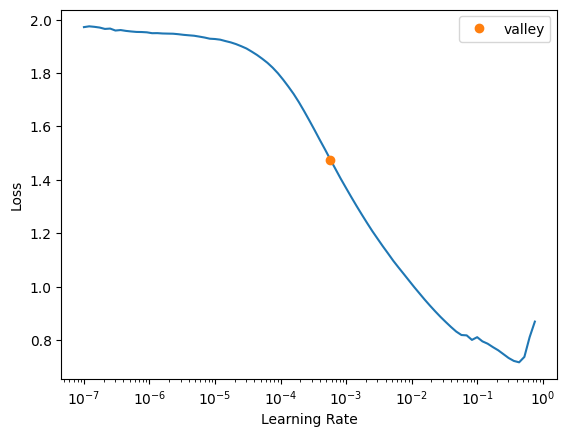

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-2)

epoch,train_loss,valid_loss,time
0,0.417090,0.259273,00:00
1,0.260617,0.178099,00:00
2,0.212959,0.129884,00:00
3,0.177681,0.500631,00:00
4,0.166331,0.183116,00:00
5,0.153983,0.118435,00:00
6,0.135843,0.083643,00:00
7,0.121639,0.098327,00:00
8,0.107940,0.088330,00:00
9,0.097622,0.078242,00:00


In [ ]:
dl_test = learn.dls.test_dl(to_test.train.xs)
pred = learn.get_preds(dl= dl_test)

In [ ]:
to.procs.vocab

['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [ ]:
to_test.procs.vocab

['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [ ]:
macro_f1 = f1_score(to_test.train.y, pred_final, average='macro')
acc_score = accuracy_score(to_test.train.y, pred_final)

print(f"Macro f1 score of neural net: {macro_f1}")
print(f"accuracy score of neural net: {acc_score}")

Macro f1 score of neural net: 0.7690880313055221
accuracy score of neural net: 0.7804546996946047


It didn't get as accurate as the logistic regression

## USING CNN

trying a basic and one-dimensional convolutional neural networks (Conv1D)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

batch_size = 128
input_channels = 1
input_length = len(to.train.xs.columns)
output_channels = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert to PyTorch tensors
xs = to.train.xs.to_numpy()
y = to.train.y.to_numpy()
x_train = torch.tensor(xs, dtype=torch.float).reshape(5881, 1, 51)
labels = torch.tensor(y, dtype=torch.long)

# Define data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, labels),
    batch_size=batch_size,
    shuffle=True
)

# Define the CNN model
class SimpleCNN1D(nn.Module):
    def __init__(self, input_channels, output_channels, input_length):
        super(SimpleCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 25, 128)
        self.fc2 = nn.Linear(128, output_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * (x.size(2)))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model, optimizer, and loss function
model = SimpleCNN1D(input_channels, output_channels, input_length)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    loss = 0.0
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"loss is: {loss}")
print("done Training")

loss is: 0.18753667175769806
loss is: 0.15740472078323364
loss is: 0.16052217781543732
loss is: 0.09209123998880386
loss is: 0.1307346373796463
loss is: 0.1014927476644516
loss is: 0.05032322183251381
loss is: 0.07383766770362854
loss is: 0.07696586847305298
loss is: 0.1028214618563652
done Training


In [ ]:
xs_test = to_test.train.xs.to_numpy()
y = to_test.train.y.to_numpy()
x_train_t = torch.tensor(xs_test, dtype=torch.float).reshape(2947, 1, 51)
labels_t = torch.tensor(to_test.train.y, dtype=torch.long)

# Define data loaders
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_t, labels_t),
    batch_size=128,
    shuffle=True
)

preds = []

# Evaluation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds.extend(outputs.argmax(dim=1))

macro_f1 = f1_score(to_test.train.y, preds, average='macro')

print(f"Macro f1 score of random forest using most important features: {macro_f1}")

Macro f1 score of random forest using most important features: 0.15856752524888482


The model performed very bad, which suggest bad model choice.

## Conclusion

Our analysis demonstrates that for this particular dataset, traditional machine learning techniques, such as logistic regression and MLP, outperform more complex models like Conv1D. The key advantage lies in the meticulous feature selection and exploratory data analysis (EDA) conducted prior to model building. By carefully identifying and preparing relevant features, we can create a strong foundation for simpler models to excel.